<a href="https://colab.research.google.com/github/saadan1234/Optical-Network-and-Technologies/blob/main/ActiveLearningT4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook I will import the previously saved model to have it's architecture and set weights to zero then perform active learning using "Diversity Sampling" and "Uncertainity Sampling" and compare results with previously trained model feature extraction and fine tuning model loss

# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras
import tensorflow as tf
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans


# Importing Data

In [ ]:
# Import the drive module from google.colab
from google.colab import drive

# Mount Google Drive to the specified folder (/content/drive)
# This allows access to files stored in your Google Drive from the Colab environment
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the file path for the Excel file stored in Google Drive
file_path = '/content/drive/MyDrive/DataSet_EU_3k_5k.xlsx'

# Use pandas to read the Excel file located at the specified file path
data = pd.read_excel(file_path)

# Display the first few rows of the dataframe to get an overview of the data
data.head()

,Power_1,Power_2,Power_3,Power_4,Power_5,Power_6,Power_7,Power_8,Power_9,Power_10,...,GSNR_69,GSNR_70,GSNR_71,GSNR_72,GSNR_73,GSNR_74,GSNR_75,GSNR_76,No. Spans,Total Distance(m)
0,0.000000,0.000000,0.000007,0.000007,0.000007,0.000000,0.000007,0.0,0.000007,0.0,...,90.061284,0.000000,0.000000,0.000000,0.000000,95.045789,0.000000,0.000000,8,690608.0
1,0.000000,0.000007,0.000000,0.000007,0.000000,0.000007,0.000000,0.0,0.000000,0.0,...,0.000000,92.560867,0.000000,0.000000,89.544975,0.000000,0.000000,0.000000,8,690608.0
2,0.000000,0.000000,0.000000,0.000007,0.000000,0.000000,0.000000,0.0,0.000007,0.0,...,0.000000,0.000000,90.991977,0.000000,0.000000,0.000000,85.512399,83.114113,8,690608.0
3,0.000007,0.000007,0.000007,0.000007,0.000007,0.000000,0.000000,0.0,0.000007,0.0,...,76.409583,73.664915,74.651700,79.071217,0.000000,0.000000,0.000000,0.000000,8,690608.0
4,0.000000,0.000000,0.000007,0.000000,0.000007,0.000000,0.000000,0.0,0.000007,0.0,...,0.000000,0.000000,78.299438,74.910765,72.030907,73.790264,81.190439,0.000000,8,690608.0


# Data Preprocessing

Correlation Matrix:
                    Power_1     ASE_1     NLI_1  No. Spans  Total Distance(m)  \
Power_1            1.000000 -0.422761  0.981919   0.463124           0.464046   
ASE_1             -0.422761  1.000000 -0.379882   0.562459           0.563680   
NLI_1              0.981919 -0.379882  1.000000   0.491886           0.493352   
No. Spans          0.463124  0.562459  0.491886   1.000000           0.999607   
Total Distance(m)  0.464046  0.563680  0.493352   0.999607           1.000000   
frequency_1             NaN       NaN       NaN        NaN                NaN   
GSNR_1             0.079878 -0.476160  0.011496  -0.435421          -0.434674   

                   frequency_1    GSNR_1  
Power_1                    NaN  0.079878  
ASE_1                      NaN -0.476160  
NLI_1                      NaN  0.011496  
No. Spans                  NaN -0.435421  
Total Distance(m)          NaN -0.434674  
frequency_1                NaN       NaN  
GSNR_1                     NaN

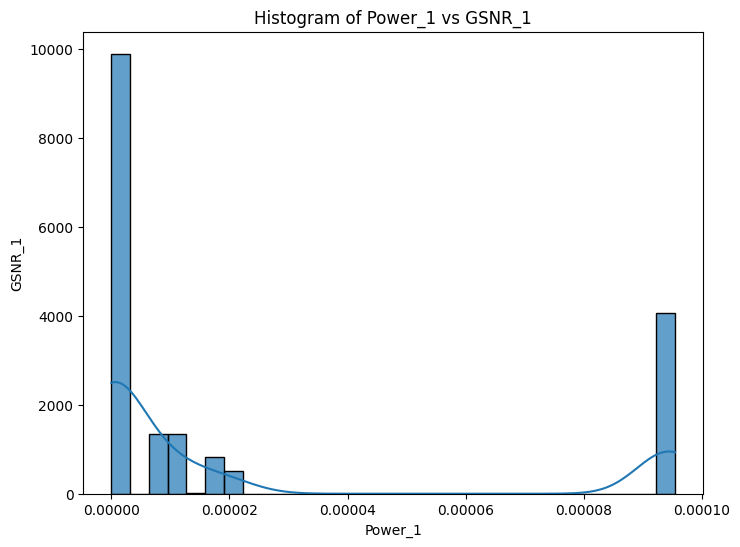

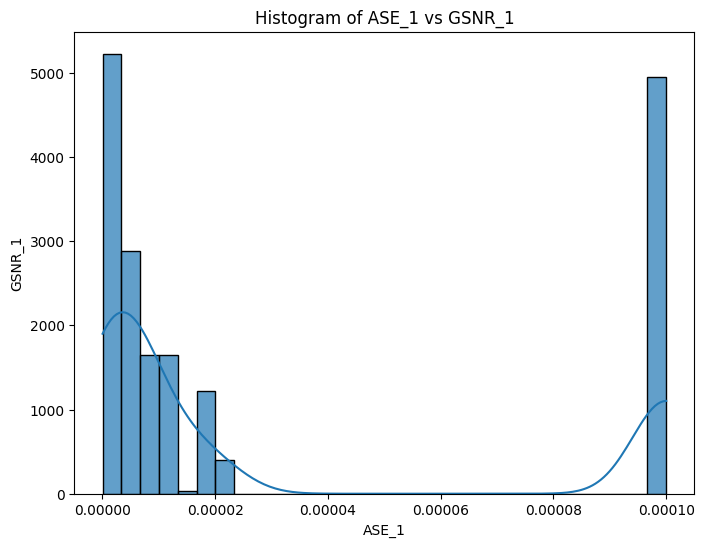

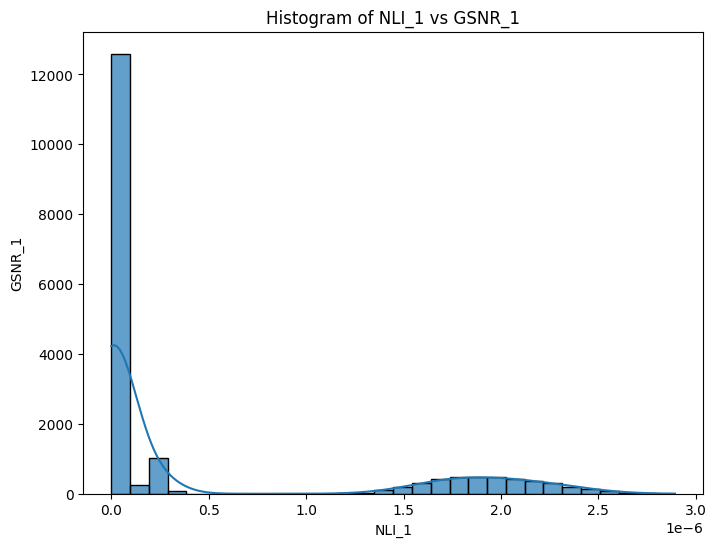

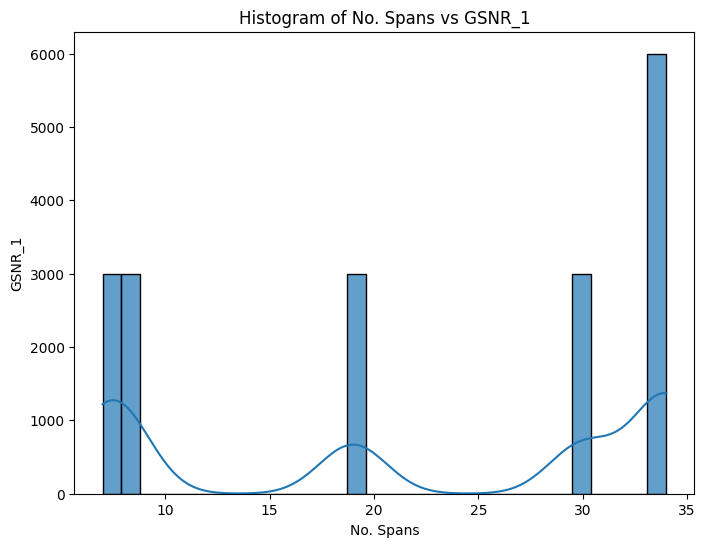

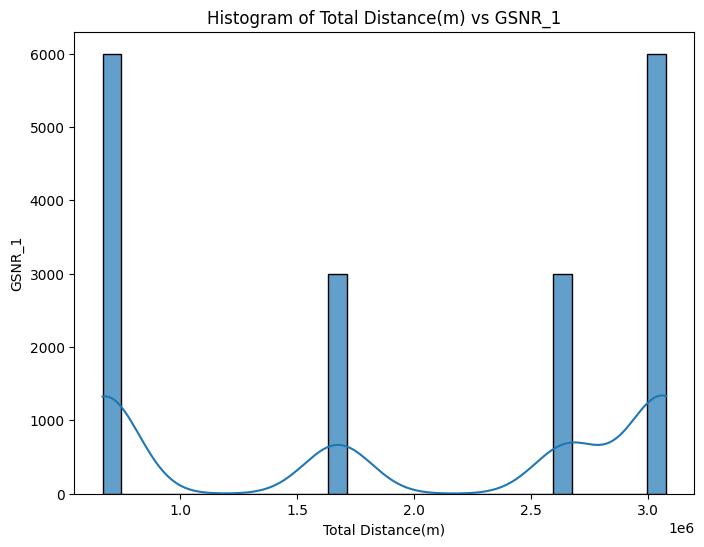

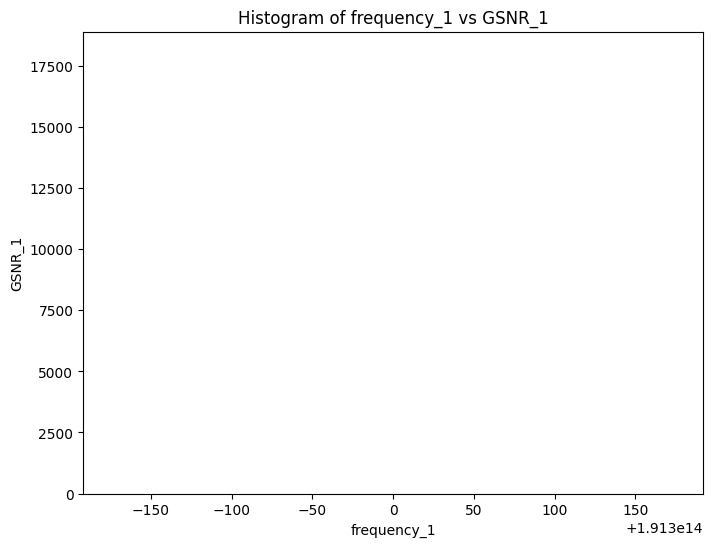

In [ ]:
# Define the attribute columns and the target variable
# Generate a list of attribute column names using list comprehensions and string formatting
attribute_columns = [f'Power_{i}' for i in range(1, 2)] + [f'ASE_{i}' for i in range(1, 2)] + [f'NLI_{i}' for i in range(1, 2)]+ ['No. Spans'] + ['Total Distance(m)'] + [f'frequency_{i}' for i in range(1, 2)]
target_column = 'GSNR_1'

# Assuming 'data' is your DataFrame containing attribute columns and the target variable
# Compute the correlation matrix for the specified columns in the DataFrame
correlation_matrix = data[attribute_columns + [target_column]].corr()

# Print the correlation matrix to understand the relationships between the attributes and the target variable
print("Correlation Matrix:")
print(correlation_matrix)

# Plot histogram plots for each attribute column against the target variable
for column in attribute_columns:
    plt.figure(figsize=(8, 6))
    # Create a histogram plot for each attribute column, including a Kernel Density Estimate (KDE) curve
    sns.histplot(data=data, x=column, kde=True, bins=30, alpha=0.7)
    plt.title(f'Histogram of {column} vs {target_column}')
    plt.xlabel(column)
    plt.ylabel(target_column)
    plt.show()

In [ ]:
# Define the attribute columns and the target variable
# Generate a list of attribute column names for 'Power', 'ASE', and 'NLI' using list comprehensions and string formatting
attribute_columns = [f'Power_{i}' for i in range(1, 77)] + [f'ASE_{i}' for i in range(1, 77)] + [f'NLI_{i}' for i in range(1, 77)]+ ['No. Spans'] + ['Total Distance(m)'] + [f'frequency_{i}' for i in range(1, 77)]

# Print the length of attribute_columns to confirm the correct number of attributes
print(len(attribute_columns))

# MinMax Normalization
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the attribute columns using MinMaxScaler and convert the result back to a DataFrame
x = scaler.fit_transform(data[attribute_columns])
x = pd.DataFrame(x, columns=attribute_columns)

# Extract the target variable values and reshape them for normalization
y = data[target_column].values.reshape(-1, 1)
# Normalize the target variable using MinMaxScaler and convert the result back to a DataFrame
y = scaler.fit_transform(y)
y = pd.DataFrame(y, columns=[target_column])

# Display the first few rows of the normalized data for selected columns
print("MinMax Normalized Data:")
print(x['Power_1'].head(), x['ASE_1'].head(), x['NLI_1'].head(), x['frequency_1'].head(), x['No. Spans'].head(), x['Total Distance(m)'].head())
print(y.head())

306
MinMax Normalized Data:
0    0.000000
1    0.000000
2    0.000000
3    0.076798
4    0.000000
Name: Power_1, dtype: float64 0    0.075117
1    0.073203
2    0.073788
3    0.000062
4    0.071547
Name: ASE_1, dtype: float64 0    0.000000
1    0.000000
2    0.000000
3    0.017928
4    0.000000
Name: NLI_1, dtype: float64 0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: frequency_1, dtype: float64 0    0.037037
1    0.037037
2    0.037037
3    0.037037
4    0.037037
Name: No. Spans, dtype: float64 0    0.008849
1    0.008849
2    0.008849
3    0.008849
4    0.008849
Name: Total Distance(m), dtype: float64
    GSNR_1
0  0.00000
1  0.00000
2  0.00000
3  0.79791
4  0.00000


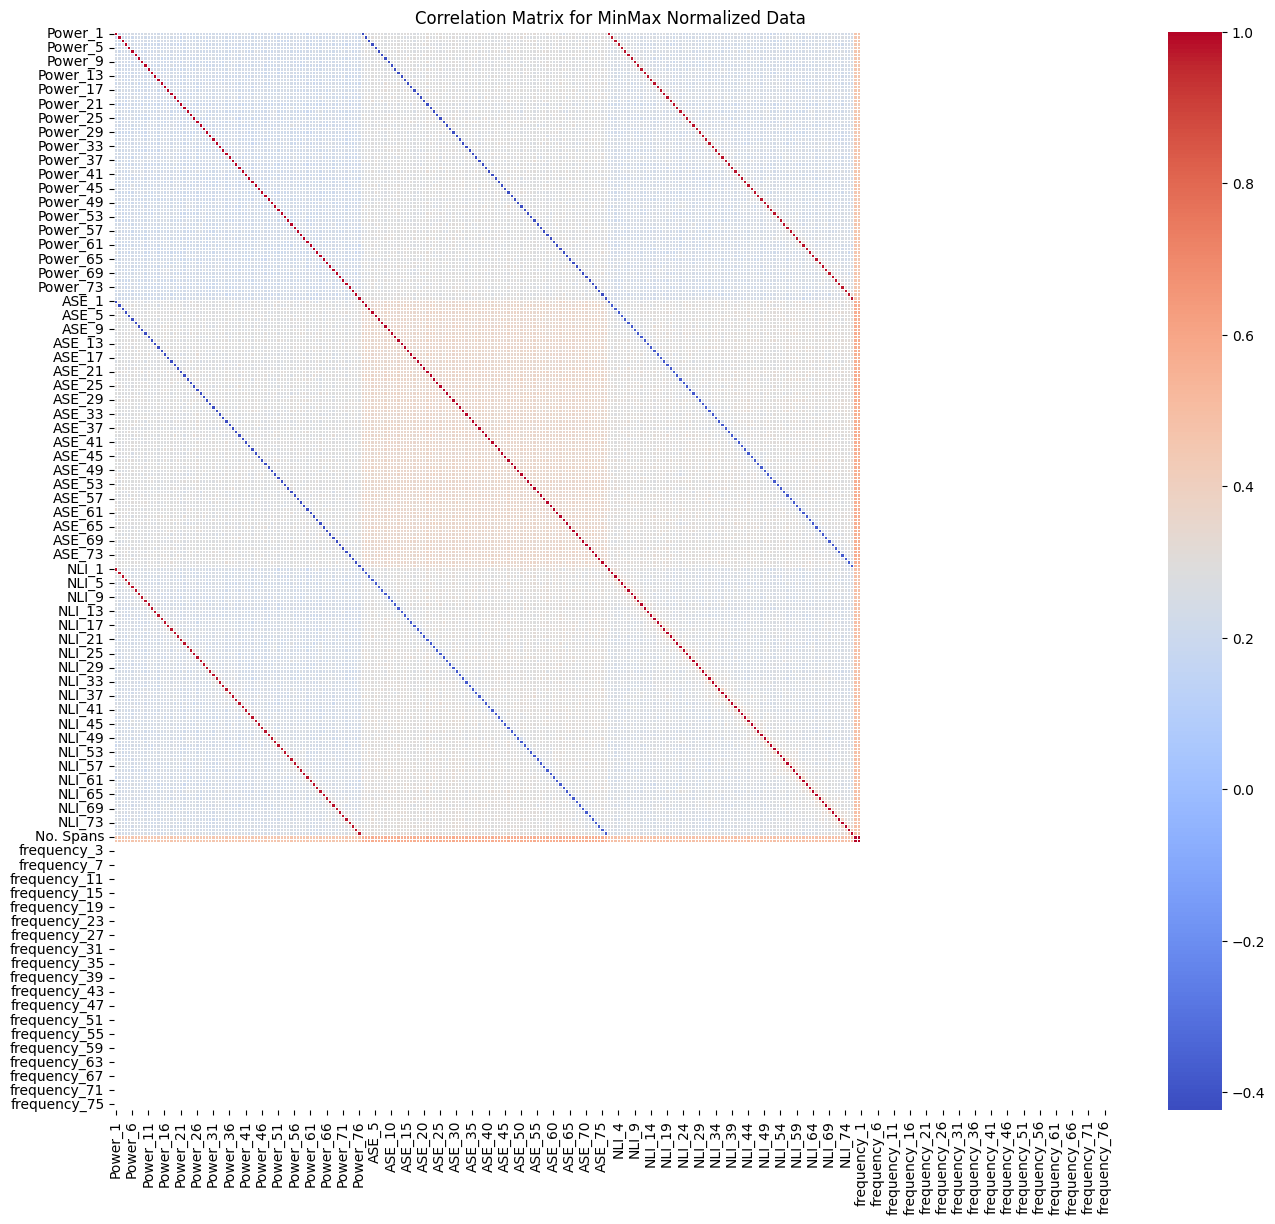

In [ ]:
# Compute correlation matrices
# MinMax Normalized Data
minmax_corr_matrix = x.corr()

# Visualize correlation matrices using heatmaps
plt.figure(figsize=(16, 14))
sns.heatmap(minmax_corr_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix for MinMax Normalized Data')
plt.show()

# The empty space at frequency column and row show that there is not any correlation due to constant values of freqency

# Path-wise Data Split

In [ ]:
# Define the function to split data according to the specified pattern
def custom_train_test_split(data, labels, samples_per_block=3000, train_samples_per_block=2500, test_samples_per_block=500):
    # Initialize lists to hold the training and testing data and labels
    train_data = []
    test_data = []
    train_labels = []
    test_labels = []

    # Determine the total number of samples in the data
    total_samples = len(data)

    # Loop over the data in blocks of the specified size (samples_per_block)
    for start in range(0, total_samples, samples_per_block):
        # Define the end of the current block
        end = start + samples_per_block
        # Define the end of the training samples within the current block
        train_end = start + train_samples_per_block

        # Adjust train_end and end if they exceed the total number of samples
        if train_end > total_samples:
            train_end = total_samples
        if end > total_samples:
            end = total_samples

        # Append the training and testing data and labels for the current block to the respective lists
        train_data.append(data[start:train_end])
        test_data.append(data[train_end:end])
        train_labels.append(labels[start:train_end])
        test_labels.append(labels[train_end:end])

    # Concatenate the lists into DataFrames and reset the index
    train_data = pd.concat(train_data).reset_index(drop=True)
    test_data = pd.concat(test_data).reset_index(drop=True)
    train_labels = pd.concat(train_labels).reset_index(drop=True)
    test_labels = pd.concat(test_labels).reset_index(drop=True)

    # Return the training and testing data and labels
    return train_data, test_data, train_labels, test_labels

# Create a list of attribute columns excluding those that start with 'frequency'
attribute_columns_without_frequency = [col for col in attribute_columns if not col.startswith('frequency')]

# Assuming 'x' and 'y' are your DataFrames for MinMax normalized data
# Perform the custom train-test split on the normalized data
X_train, X_test, Y_train, Y_test = custom_train_test_split(x[attribute_columns_without_frequency], y[target_column])

# Display shapes to verify the split
print("\nMinMax normalized data:")
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Train labels shape:", Y_train.shape)
print("Test labels shape:", Y_test.shape)


MinMax normalized data:
Train data shape: (15000, 230)
Test data shape: (3000, 230)
Train labels shape: (15000,)
Test labels shape: (3000,)


# Model Architecture

In [ ]:
# Define the path to save the model
pre_trained_model_path = '/content/drive/MyDrive/models/bestmodel.h5'

# Load pre-trained model to compare transfer learning vs active learning
model = tf.keras.models.load_model(pre_trained_model_path)

# Set all weights in the model to zero
for layer in model.layers:
    layer.set_weights([tf.zeros_like(w) for w in layer.get_weights()])

# Confirm weights after setting to zero for active learnin
print("\nAfter setting weights to zero:")
print(model.get_weights())


After setting weights to zero:
[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dty

# Training Data Split ffor Active Learning

In [ ]:
def initialize_training_set(X, Y, initial_train_size=600):
    """
    Initialize the training set with a random subset of the data.

    Parameters:
    X (array-like): Feature data.
    Y (array-like): Target data.
    initial_train_size (int): Number of samples to include in the initial training set.

    Returns:
    X_initial (array-like): Initial training feature data.
    Y_initial (array-like): Initial training target data.
    X_pool (array-like): Remaining feature data to be used as a pool for further training.
    Y_pool (array-like): Remaining target data to be used as a pool for further training.
    """
    # Randomly select indices for the initial training set using resample
    initial_indices = resample(range(len(Y)), n_samples=initial_train_size, random_state=42)

    # Extract the initial training data and labels based on the selected indices
    X_initial = X[initial_indices]
    Y_initial = Y[initial_indices]

    # Remove the initial training data and labels from the original data to create the pool
    X_pool = np.delete(X, initial_indices, axis=0)
    Y_pool = np.delete(Y, initial_indices, axis=0)

    return X_initial, Y_initial, X_pool, Y_pool

# Oracle (Mimic Human Requirement)

In [ ]:
# Function to query oracle
def query_oracle(X_query, X_pool, Y_pool):
    query_indices = [np.where(np.all(X_pool == x, axis=1))[0][0] for x in X_query]
    y_query = Y_pool[query_indices]
    return y_query

In [ ]:
# Define the number of maximum iterations for the training process
max_iterations = 25

# Define the number of instances to be added to the training set in each iteration
n_instances_per_iter = 300

# Initialize an empty list to store the performance metrics for each iteration
performance = []

# Uncertainty Sample Training

In [ ]:
# Uncertainty sampling function
def uncertainty_sampling(model, X_pool, n_instances=600):
    """
    Perform uncertainty sampling to select the most uncertain instances from the pool.

    Parameters:
    model (sklearn model): Trained model used to predict probabilities.
    X_pool (array-like): Pool of feature data from which to select uncertain instances.
    n_instances (int): Number of instances to select based on uncertainty.

    Returns:
    query_idx (array-like): Indices of the selected most uncertain instances.
    """
    # Predict probabilities for the instances in the pool
    probs = model.predict(X_pool)

    # Calculate uncertainty as 1 - max probability
    uncertainty = 1 - np.max(probs, axis=1)

    # Select the indices of the n_instances most uncertain instances
    query_idx = np.argsort(uncertainty)[-n_instances:]

    return query_idx

In [ ]:
# Assume data is already in numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

# Initialize training and pool sets
X_initial, Y_initial, X_pool, Y_pool = initialize_training_set(X_train, Y_train, initial_train_size=600)

In [ ]:
# Load pre-trained model to compare transfer learning vs active learning
model = tf.keras.models.load_model(pre_trained_model_path)

# Set all weights in the model to zero
for layer in model.layers:
    layer.set_weights([tf.zeros_like(w) for w in layer.get_weights()])

# Confirm weights after setting to zero for active learnin
print("\nAfter setting weights to zero:")
print(model.get_weights())


After setting weights to zero:
[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dty

In [ ]:
for i in range(max_iterations):
    print(f"Iteration {i+1}")

    # Uncertainty sampling to select the most uncertain instances from the pool
    query_idx = uncertainty_sampling(model, X_pool, n_instances=n_instances_per_iter)
    X_query = X_pool[query_idx]
    y_query = query_oracle(X_query, X_pool, Y_pool)  # Querying the labels

    # Update the training set by adding the newly selected instances
    X_initial = np.concatenate([X_initial, X_query])
    Y_initial = np.concatenate([Y_initial, y_query])

    # Remove the selected instances from the pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    Y_pool = np.delete(Y_pool, query_idx, axis=0)

    # Retrain the model with the updated training set
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)  # Smaller learning rate for fine-tuning
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    # Train the model with early stopping to prevent overfitting
    history = model.fit(X_initial, Y_initial, epochs=100, batch_size=64, validation_data=(X_test, Y_test),
                        callbacks=[keras.callbacks.EarlyStopping(patience=5)], verbose=1)

    # Evaluate the model on the test set
    results = model.evaluate(X_test, Y_test)
    performance.append(results[1])
    print(f"Iteration {i+1}, Loss: {results[0]}, MSE: {results[1]}")

    # Check if the loss has reached the defined threshold and stop training if it has
    if results[0] <= 0.00025:
        print(f"Stopping training as loss reached the threshold of 0.00025 that of fine tuning")
        break

# Print the shapes of the data pools and the initial training set after the training process
print("X_pool shape after training:", X_pool.shape)
print("Y_pool shape after training:", Y_pool.shape)
print("X_initial shape after training:", X_initial.shape)
print("Y_initial shape after training", Y_initial.shape)

Iteration 1
348/348 [==============================] - 1s 3ms/step
Epoch 1/100
66/66 [==============================] - 3s 8ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.1143 - val_mse: 0.1143
Epoch 2/100
66/66 [==============================] - 0s 4ms/step - loss: 0.0274 - mse: 0.0274 - val_loss: 0.1120 - val_mse: 0.1120
Epoch 3/100
66/66 [==============================] - 0s 6ms/step - loss: 0.0264 - mse: 0.0264 - val_loss: 0.1098 - val_mse: 0.1098
Epoch 4/100
66/66 [==============================] - 0s 5ms/step - loss: 0.0255 - mse: 0.0255 - val_loss: 0.1078 - val_mse: 0.1078
Epoch 5/100
66/66 [==============================] - 0s 4ms/step - loss: 0.0247 - mse: 0.0247 - val_loss: 0.1059 - val_mse: 0.1059
Epoch 6/100
66/66 [==============================] - 0s 5ms/step - loss: 0.0240 - mse: 0.0240 - val_loss: 0.1041 - val_mse: 0.1041
Epoch 7/100
66/66 [==============================] - 0s 4ms/step - loss: 0.0234 - mse: 0.0234 - val_loss: 0.1025 - val_mse: 0.1025
Epoch 8/100
66/6

# Diversity Sample Training

In [ ]:
# Initialize training and pool sets
X_initial, Y_initial, X_pool, Y_pool = initialize_training_set(X_train, Y_train, initial_train_size=600)

# Diversity sampling using k-medoids
def diversity_sampling(model, X_pool, n_instances=600):
    # Calculate pairwise distances
    distances = pairwise_distances(X_pool, metric='euclidean')

    # Initialize centroids (medoids) using k-means++
    np.random.seed(0)  # Ensure reproducibility
    centroids = [np.random.choice(len(X_pool))]  # Start with a random point
    while len(centroids) < n_instances:
        # Calculate minimum distance from each point to its nearest centroid
        min_distances = np.min(distances[:, centroids], axis=1)

        # Choose the point with the maximum minimum distance as the next centroid (medoid)
        new_centroid = np.argmax(min_distances)

        # Add new centroid to list
        centroids.append(new_centroid)

    query_idx = np.array(centroids)


    return query_idx

In [ ]:
# Load pre-trained model to compare transfer learning vs active learning
model = tf.keras.models.load_model(pre_trained_model_path)

# Set all weights in the model to zero
for layer in model.layers:
    layer.set_weights([tf.zeros_like(w) for w in layer.get_weights()])

# Confirm weights after setting to zero for active learnin
print("\nAfter setting weights to zero:")
print(model.get_weights())


After setting weights to zero:
[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dty

In [ ]:
for i in range(max_iterations):
    print(f"Iteration {i+1}")
    # Uncertainty sampling
    query_idx = diversity_sampling(model, X_pool, n_instances=n_instances_per_iter)
    X_query = X_pool[query_idx]
    y_query = query_oracle(X_query, X_pool, Y_pool)  # Querying the labels

    # Update training and pool sets
    X_initial = np.concatenate([X_initial, X_query])
    Y_initial = np.concatenate([Y_initial, y_query])
    X_pool = np.delete(X_pool, query_idx, axis=0)
    Y_pool = np.delete(Y_pool, query_idx, axis=0)

    # Retrain model
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)  # Smaller learning rate for fine-tuning
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    history = model.fit(X_initial, Y_initial, epochs=100, batch_size=64, validation_data=(X_test, Y_test),
                        callbacks=[keras.callbacks.EarlyStopping(patience=5)], verbose=1)

    # Evaluate model
    results = model.evaluate(X_test, Y_test)
    performance.append(results[1])
    print(f"Iteration {i+1}, Loss: {results[0]}, MSE: {results[1]}")

    # Check if the loss is below the threshold
    if results[0] <= 0.00025:
        print(f"Stopping training as loss reached the threshold of 0.00025 that of fine tuning")
        break

print("X_pool shape after training:", X_pool.shape)
print("Y_pool shape after training:", Y_pool.shape)
print("X_initial shape after training:", X_initial.shape)
print("Y_initial shape after training:", Y_initial.shape)

Iteration 1
Epoch 1/100
15/15 [==============================] - 2s 28ms/step - loss: 0.0827 - mse: 0.0827 - val_loss: 0.1162 - val_mse: 0.1162
Epoch 2/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0823 - mse: 0.0823 - val_loss: 0.1156 - val_mse: 0.1156
Epoch 3/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0818 - mse: 0.0818 - val_loss: 0.1151 - val_mse: 0.1151
Epoch 4/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0814 - mse: 0.0814 - val_loss: 0.1145 - val_mse: 0.1145
Epoch 5/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0810 - mse: 0.0810 - val_loss: 0.1139 - val_mse: 0.1139
Epoch 6/100
15/15 [==============================] - 0s 14ms/step - loss: 0.0805 - mse: 0.0805 - val_loss: 0.1134 - val_mse: 0.1134
Epoch 7/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0801 - mse: 0.0801 - val_loss: 0.1128 - val_mse: 0.1128
Epoch 8/100
15/15 [==============================] - 0s 11ms/step

# Comparison

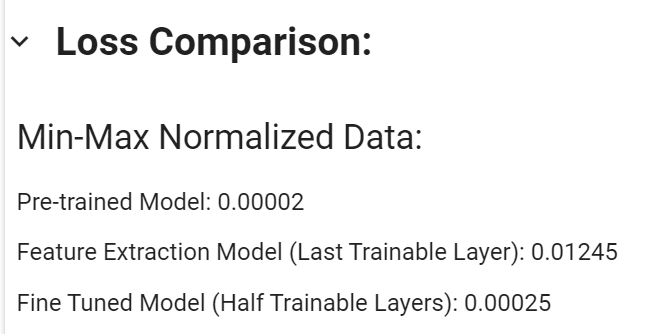

# Active Learing Loss

**Task and Data Availability:**

If you have a small amount of labeled data or labeling is expensive, active learning might be more beneficial as it optimizes the use of these labels.

If you have access to a large amount of labeled data or a pre-trained model that is suitable for your task, transfer learning could be more effective and efficient.

**Nature of the Task:**

For tasks where the data distribution is similar to the pre-training task of a transfer learning model, transfer learning tends to work well.

For tasks where certain data points are more informative or critical (such as anomaly detection or rare event classification), active learning can be very effective.

# My Learnings:

The provided dataset is for a regression task and this to fit a line over all datapoints active learning is not useful as all points are significant. Thus active learning more suits for classification and machine learning models.

An active learning task cannot be compared in terms of loss to a fine tuned or feature extraction model as they are already pre-trained on a large amount of data and further improved using another dataset while active learning is a process to initially train a model.